Load the gan checkpoint from github

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# python dcgan.py --dataset cifar10 --dataroot /scratch/users/vision/yu_dl/raaz.rsk/data/cifar10 --imageSize 32 --cuda --outf out_cifar --manualSeed 13 --niter 100

class Generator_cifar10(nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator_cifar10, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Discriminator_cifar10(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator_cifar10, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [ ]:
#!wget https://github.com/stat-ml/ex2mcmc/blob/refactoring/dcgan_code/models/models_cifar10/netD_epoch_199.pth

#!wget https://github.com/stat-ml/ex2mcmc/blob/refactoring/dcgan_code/models/models_cifar10/netG_epoch_199.pth

Model generator getnerate images from checkpoint

In [2]:
Generator=Generator_cifar10(ngpu=1)
Discriminator=Discriminator_cifar10(ngpu=1)

In [4]:
Gpath_to_checkpoint='/content/netG_epoch_199.pth'
Dpath_to_checkpoint='/content/netD_epoch_199.pth'
#torch.load(path_to_checkpoint)
Generator.load_state_dict(torch.load(Gpath_to_checkpoint,map_location=torch.device('cpu')), 
                           strict=False)

Discriminator.load_state_dict(torch.load(Dpath_to_checkpoint, map_location=torch.device('cpu')), 
                           strict=False)
device='cuda:0'
if torch.cuda.is_available():
    Discriminator = Discriminator.to(device).eval()
    Generator = Generator.to(device).eval()

Visualisation

In [ ]:
N_gen = 1000
noize_dim = 100
img_gen_batch=Generator(torch.rand([N_gen, noize_dim]).unsqueeze(-1).unsqueeze(-1))

In [ ]:
print(img_gen_batch.shape)

torch.Size([1000, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


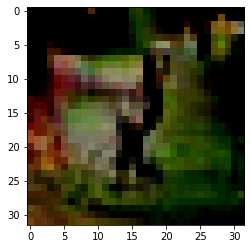

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
def normalize_img(img):
  #images normalized in the range [-1, 1]

  return 2*(img-torch.max(img))/(torch.max(img)-torch.min(img))-1

plt.imshow(img_gen_batch[101,:,:,:].permute(1,2,0).cpu().detach().numpy())

Calculating inception score on images generated

In [5]:
#code for inception score calculation from github


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [6]:
class Dataset(torch.utils.data.Dataset):
        def __init__(self, orig):
            self.orig = orig

        def __getitem__(self, index):
            return self.orig[index][0]

        def __len__(self):
            return len(self.orig)

import torchvision.datasets as dset
import torchvision.transforms as transforms

cifar = dset.CIFAR10(root='data/', download=True,
                          transform=transforms.Compose([
                              transforms.Scale(32),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ])
)



print(inception_score(Dataset(cifar), cuda=True, batch_size=32, resize=True, splits=10))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(9.67277326176692, 0.14991244791238015)


In [8]:
N_gen = 3200
noize_dim = 100
img_gen_batch=Generator(torch.rand([N_gen, noize_dim]).unsqueeze(-1).unsqueeze(-1).to(device))
dataset_imgs=Dataset(img_gen_batch)
print(inception_score(img_gen_batch, cuda=True, batch_size=32, resize=True, splits=10))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(1.7160167492548475, 0.03562573695043372)
